## 1. Project Background
Accurate information on forest cover is important for supporting forest conservation and management efforts. Traditional methods of determining forest cover such as ground-based surveys are very tedious, expensive and time consuming.

Advanced methods, such as remote sensing coupled with robust geographical information systems (GIS) present an opportunity for cost effective and large scale forest cover mapping. However they still rely on very simple classification algorithms and require experts to manually draw polygons over the various classes (Gachuhi & Kibui, 2024). Other advanced approaches to forest mapping involve using indices derived from satellite imagery such as the Normalised Difference Vegetative Index (NDVI), but this too is prone to inaccuracies because it is easily affected by conditions such as soil moisture and NDVI cannot differentiate between very similar classes such as a shrub and a forest (Cropin, 2021).

To counter these limitations, deep learning techniques can be used to automate the process of identifying forested areas from satellite images. One such technique is semantic segmentation which is a computer vision task that classifies each pixel in an input image into specific classes resulting in a dense pixel-wise feature map.

## 2. Data Loading & Preprocessing

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random 
import cv2

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout,concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

from sklearn.model_selection import train_test_split

In [2]:
#define paths to the data on local drive
img_dir=r'C:\Users\Admin\Desktop\Capstone_project_research\images'
mask_dir=r'C:\Users\Admin\Desktop\Capstone_project_research\masks'

#define batch size-how many images will be taken at a time during training
batch_size=50

In [3]:
# load data using a generator for efficiency
def image_generator(image_dir, mask_dir, batch_size):


#create a list of paths for each image/mask
  image_filenames=sorted(os.listdir(img_dir))
  mask_filenames=sorted(os.listdir(mask_dir))


  while True:
    for i in range(0,len(image_filenames),batch_size):
      image_filepaths_batch=image_filenames[i:i+batch_size]
      masks_filepatch_batch=mask_filenames[i:i+batch_size]

      images=[]
      masks=[]

      #load each image/mask in the batch
      for image_name,mask_name in zip(image_filenames,mask_filenames):
          img_path=os.path.join(img_dir,image_name)
          img=tf.keras.preprocessing.image.load_img(img_path)
          img=tf.keras.preprocessing.image.img_to_array(img)/255

          msk_path=os.path.join(mask_dir,mask_name)
          msk=tf.keras.preprocessing.image.load_img(msk_path, color_mode='grayscale')
          msk=tf.keras.preprocessing.image.img_to_array(msk)/255

          images.append(img)
          masks.append(msk)
      yield np.array(images), np.array(masks)

In [4]:
#for x in image_generator(img_dir,mask_dir,batch_size):
   # print(x)
#the function produces an array of the first 50 images

In [5]:
X_batch,y_batch=next(image_generator(img_dir,mask_dir,batch_size))

In [6]:
print(X_batch.shape)

(5108, 256, 256, 3)


Image path: C:\Users\Admin\Desktop\Capstone_project_research\images\906113_sat_76.jpg
Mask path: C:\Users\Admin\Desktop\Capstone_project_research\masks\906113_mask_76.jpg


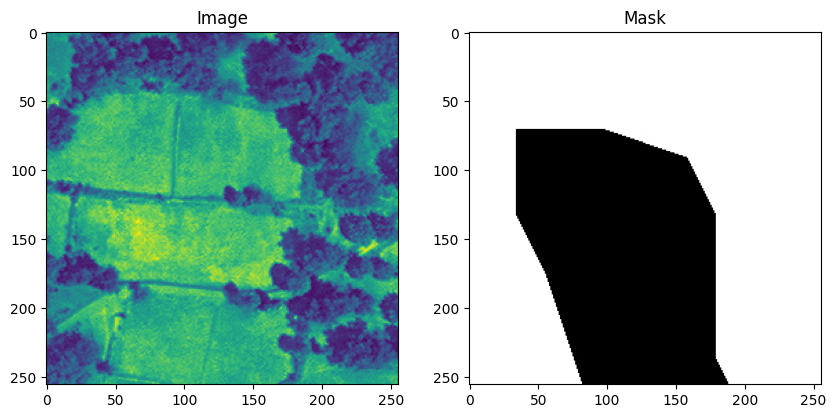

In [7]:

num_images=len(os.listdir(img_dir))
img_num = random.randint(0, num_images-1)

# Get the list of image and mask filenames
image_filenames=sorted(os.listdir(img_dir))
mask_filenames=sorted(os.listdir(mask_dir))

# Paths for the randomly selected image/masks pair
img_path = os.path.join(img_dir, image_filenames[img_num]) 
mask_path = os.path.join(mask_dir, mask_filenames[img_num])

# Print the paths for verification
print("Image path:", img_path)
print("Mask path:", mask_path)

# Load the image and mask
img_for_plot = cv2.imread(img_path, 0)
mask_for_plot = cv2.imread(mask_path, 0)

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.imshow(img_for_plot, cmap='viridis')
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

## 3. Build the models

### 3.1 Fully Convolutional Network

In [8]:
def FCN(inputs):
    #encoder block
    conv1=tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(inputs)
    conv1=tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(conv1)
    pool1=tf.keras.layers.MaxPooling2D((2,2))(conv1)

    conv2=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(pool1)
    conv2=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(conv2)
    pool2=tf.keras.layers.MaxPooling2D((2,2))(conv2)

    conv3=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(pool2)
    conv3=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(conv3)
    pool3=tf.keras.layers.MaxPooling2D((2,2))(conv3)

    conv4=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(pool3)
    conv4=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(conv4)
    pool4=tf.keras.layers.MaxPooling2D((2,2))(conv4)

    #decoder
    up5=tf.keras.layers.Conv2DTranspose(256,(2,2),strides=(2,2), padding='same')(pool4)
    conv5=tf.keras.layers.Conv2D(256,(3,3), activation='relu',padding='same')(up5)
    
    up6=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2), padding='same')(conv5)
    conv6=tf.keras.layers.Conv2D(128,(3,3), activation='relu',padding='same')(up6)
  
    up7=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2), padding='same')(conv6)
    conv7=tf.keras.layers.Conv2D(64,(3,3), activation='relu',padding='same')(up7)
   
    up8=tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2), padding='same')(conv7)
    conv8=tf.keras.layers.Conv2D(32,(3,3), activation='relu',padding='same')(up8)
   

    output=tf.keras.layers.Conv2D(1,(1,1), activation='sigmoid')(conv8)

    return output

In [9]:
#compile the model
inputs= tf.keras.Input(shape=(256,256,3))
outputs=FCN(inputs)
model=tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 256)    │       262,400 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 128)    │       131,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 64)   │        32,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 256, 256, 32)   │         8,224 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,390,785 (9.12 MB)

 Trainable params: 2,390,785 (9.12 MB)

 Non-trainable params: 0 (0.00 B)

Mental note: I have only 7 layers in my network-but the model.summary() outputs more than those? How come?

### 3.2 U-net model

In [10]:
def UNET (input):
    #contracting path
    conv1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(input)
    conv1=keras.layers.Dropout(0.1)(conv1)
    conv1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(conv1)
    pool1=tf.keras.layers.MaxPooling2D((2,2))(conv1)
    
    conv2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(pool1)
    conv2=keras.layers.Dropout(0.1)(conv2)
    conv2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(conv2)
    pool2=tf.keras.layers.MaxPooling2D((2,2))(conv2)
    
    conv3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(pool2)
    conv3=keras.layers.Dropout(0.1)(conv3)
    conv3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(conv3)
    pool3=tf.keras.layers.MaxPooling2D((2,2))(conv3)

    conv4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(pool3)
    conv4=keras.layers.Dropout(0.1)(conv4)
    conv4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(conv4)
    pool4=tf.keras.layers.MaxPooling2D((2,2))(conv4)
    
    #bottle neck layer
    conv5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(pool4)
    conv5=keras.layers.Dropout(0.1)(conv5)
    conv5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(conv5)
    

    #expanding path
    up6=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2), padding='same')(conv5)
    up6=tf.keras.layers.concatenate([up6,conv4])
    conv6=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(up6)
    conv6=keras.layers.Dropout(0.1)(conv6)
    conv6=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(conv6)

    up7=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2), padding='same')(conv6)
    up7=tf.keras.layers.concatenate([up7,conv3])
    conv7=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(up7)
    conv7=keras.layers.Dropout(0.1)(conv7)
    conv7=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(conv7)

    up8=tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2), padding='same')(conv7)
    up8=tf.keras.layers.concatenate([up8,conv2])
    conv8=tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(up8)
    conv8=keras.layers.Dropout(0.1)(conv8)
    conv8=tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(conv8)

    up9=tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2), padding='same')(conv8)
    up9=tf.keras.layers.concatenate([up9,conv1])
    conv9=tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(up9)
    conv9=keras.layers.Dropout(0.1)(conv9)
    conv9=tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(conv9)

    output=tf.keras.layers.Conv2D(1,(1,1), activation='sigmoid')(conv9)

    return output

In [11]:
#compile the model
inputs= tf.keras.Input(shape=(256,256,3))
outputs=UNET(inputs)
model_unet=tf.keras.Model(inputs=inputs, outputs=outputs)
model_unet.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

model_unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d_13[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_15[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_17[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_19[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_20[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Train the models

#### Split data into train, validation and test sets

In [12]:
#split data into test and train
X_train, X_temp, y_train, y_temp = train_test_split(X_batch, y_batch, test_size=0.2, random_state=42)
X_val,X_test, y_val,y_test=train_test_split(X_temp,y_temp)

#### 4.1 Train the Fully Convolutional Network

In [13]:
early_stopper=EarlyStopping(monitor='val_loss',patience=5)

history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=early_stopper)             

Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 1620s 20s/step - accuracy: 0.6129 - loss: 0.7040 - val_accuracy: 0.5940 - val_loss: 0.6734
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 1610s 20s/step - accuracy: 0.6091 - loss: 0.6657 - val_accuracy: 0.5940 - val_loss: 0.6728
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 1555s 19s/step - accuracy: 0.6070 - loss: 0.6667 - val_accuracy: 0.5940 - val_loss: 0.6727
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 1699s 21s/step - accuracy: 0.6080 - loss: 0.6660 - val_accuracy: 0.5940 - val_loss: 0.6732
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 1797s 22s/step - accuracy: 0.6106 - loss: 0.6653 - val_accuracy: 0.5940 - val_loss: 0.6728


##### 4.1.1 Save the trained FCN model

In [14]:
model.save('fcn_model.keras')
from tensorflow.keras.models import load_model
trained_fcn_model=load_model('fcn_model.keras')
trained_fcn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 256)    │       262,400 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 128)    │       131,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 64)   │        32,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 256, 256, 32)   │         8,224 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,172,357 (27.36 MB)

 Trainable params: 2,390,785 (9.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,781,572 (18.24 MB)

#### 4.2 Train the U-net model

In [15]:
early_stopper=EarlyStopping(monitor='val_loss',patience=5)

history = model_unet.fit(
    X_train, y_train,
    epochs=5,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=early_stopper)  

Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 2830s 35s/step - accuracy: 0.6316 - loss: 0.6525 - val_accuracy: 0.6787 - val_loss: 0.6274
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 781s 10s/step - accuracy: 0.7104 - loss: 0.5707 - val_accuracy: 0.7233 - val_loss: 0.5557
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 740s 9s/step - accuracy: 0.7232 - loss: 0.5561 - val_accuracy: 0.7310 - val_loss: 0.5448
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 743s 9s/step - accuracy: 0.7541 - loss: 0.5185 - val_accuracy: 0.7292 - val_loss: 0.5789
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 723s 9s/step - accuracy: 0.7528 - loss: 0.5215 - val_accuracy: 0.7483 - val_loss: 0.5092


##### 4.2.2 Save the trained U-net model

In [16]:
model_unet.save('unet_model.keras')
from tensorflow.keras.models import load_model
trained_unet_model=load_model('unet_model.keras')
#trained_unet_model.summary()

## 5. HyperParameter Tuning

## 6. Model Testing & Evaluation

In [17]:
#predicted_masks=trained_unet_model.predict(X_val)

In [18]:
#evaluation=trained_unet_model.evaluate(X_val,y_val)
#print(f'Loss: {evaluation[0]}')
#print(f'Accuracy: {evaluation[1]}')